In [1]:
import tushare as ts
import pandas as pd
import statsmodels.tsa.stattools as stat
import numpy as np

In [2]:
pro = ts.pro_api()
pro = ts.pro_api('f7ee2dda50509f466b74a0eb3cbbe9a60b6c6cf16e3005949cf70672')
data = pro.daily(ts_code='600519.SH')

In [3]:
data = data.sort_values('trade_date')
data['trade_date'] = pd.to_datetime(data['trade_date'])
data.set_index('trade_date',inplace=True)

In [4]:
sub_data = data.iloc[:-30,[1,4,3,2]]
sub_data

,open,close,low,high
trade_date,,,,
2001-08-27,34.51,35.55,32.85,37.78
2001-08-28,34.99,36.86,34.61,37.00
2001-08-29,36.98,36.38,36.10,37.00
2001-08-30,36.28,37.10,36.00,37.51
2001-08-31,37.15,37.01,36.80,37.62
...,...,...,...,...
2021-05-20,2074.00,2058.88,2045.36,2074.10
2021-05-21,2055.08,2042.10,2037.02,2079.88
2021-05-24,2051.00,2071.29,2031.00,2080.06


In [5]:
for i in range(4):
    p_value = stat.adfuller(sub_data.values[:, i], 1)[1]
    print("指标 ", sub_data.columns[i], " 单位根检验的p值为：", p_value)

指标  open  单位根检验的p值为： 1.0
指标  close  单位根检验的p值为： 1.0
指标  low  单位根检验的p值为： 1.0
指标  high  单位根检验的p值为： 1.0


In [6]:
sub_data_diff1 = sub_data.iloc[1:, :].values - sub_data.iloc[:-1, :].values
for i in range(4):
    p_value = stat.adfuller(sub_data_diff1[:, i], 1)[1]
    print("指标 ", sub_data.columns[i], " 单位根检验的p值为：", p_value)

指标  open  单位根检验的p值为： 0.0
指标  close  单位根检验的p值为： 0.0
指标  low  单位根检验的p值为： 0.0
指标  high  单位根检验的p值为： 0.0


In [7]:
rows, cols = sub_data_diff1.shape
aicList = []
lmList = []

In [8]:
for p in range(1, 11):
    baseData = None
    for i in range(p, rows):
        tmp_list = list(sub_data_diff1[i, :]) + list(sub_data_diff1[i - p:i].flatten())
        if baseData is None:
            baseData = [tmp_list]
        else:
            baseData = np.r_[baseData, [tmp_list]]
    X = np.c_[[1] * baseData.shape[0], baseData[:, cols:]]
    Y = baseData[:, 0:cols]
    coef_matrix = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), Y)
    aic = np.log(np.linalg.det(np.cov(Y - np.matmul(X, coef_matrix), rowvar=False))) + 2 * (
                coef_matrix.shape[0] - 1) ** 2 * p / baseData.shape[0]
    aicList.append(aic)
    lmList.append(coef_matrix)

In [9]:
pd.DataFrame({"P": range(1, 11), "AIC": aicList})

,P,AIC
0,1,14.500593
1,2,14.018470
2,3,13.882146
3,4,14.023159
4,5,14.262996
5,6,14.777954
6,7,15.600241
7,8,16.675566
8,9,18.087112
9,10,19.875426


In [17]:
p = np.argmin(aicList) + 1
n = rows
pred_df = None

In [20]:
data.iloc[n + 1, :].values[1:5]

array([2211.02, 2320.0, 2201.1, 2245.0], dtype=object)

In [21]:
for i in range(30):
    pred_data = list(sub_data_diff1[n + i - p:n + i].flatten())
    pred_val = np.matmul([1] + pred_data, lmList[p - 1])
    # 使用逆差分运算，还原预测值
    pred_val = data.iloc[n + i, :].values[1:5] + pred_val
    if pred_df is None:
        pred_df = [pred_val]
    else:
        pred_df = np.r_[pred_df, [pred_val]]
    # 为sub_data_diff1增加一条新记录
    sub_data_diff1 = np.r_[sub_data_diff1, [data.iloc[n + i + 1, :].values[1:5] - data.iloc[n + i, :].values[1:5]]]


In [23]:
(np.abs(pred_df - data.iloc[-30:data.shape[0], 1:5]) / data.iloc[-30:data.shape[0], 1:5]).describe()

,open,high,low,close
count,30.000000,30.000000,30.000000,30.000000
unique,30.000000,30.000000,30.000000,30.000000
top,0.001468,0.036965,0.009824,0.008472
freq,1.000000,1.000000,1.000000,1.000000


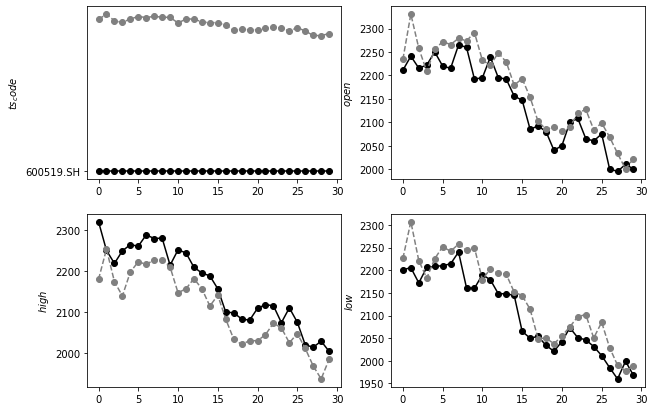

Evaluation on test data: accuracy = 98.69% 



In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 7))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(30), data.iloc[-30:data.shape[0], i].values, 'o-', c='black')
    plt.plot(range(30), pred_df[:, i], 'o--', c='gray')
#     plt.ylim(1000, 1200)
    plt.ylabel("$" + data.columns[i] + "$")
plt.show()
v = 100 * (1 - np.sum(np.abs(pred_df - data.iloc[-30:data.shape[0], 1:5]).values) / np.sum(data.iloc[-30:data.shape[0], 1:5].values))
print("Evaluation on test data: accuracy = %0.2f%% \n" % v)